### Installing the openslide libraries

In [1]:
!apt-get install openslide-tools
!pip install openslide-python
!pip install ipython-autotime
%load_ext autotime

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (202 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 160690 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
import shutil
import random
import pickle
from PIL import Image
from skimage.color import rgb2gray

time: 241 ms (started: 2021-04-30 13:04:33 +00:00)


In [3]:
# mounting the drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/
time: 14.1 s (started: 2021-04-30 13:04:34 +00:00)


### Storing the data in a lists

Since we are given tiff files as input, the idea is to convert them into a dataset which can be given to the model as input.

The directory structure of the dataset is as follows:
- dataset/
    - tumor/
    - tumor_mask/
    - test
        - tumor/
        - tumor_mask/

The test folder contains two tiff files. These files are, 101.tiff and 110.tiff.
Since, we are given only 21 such tiff files, only two were enough to demonstrate the predictive power of the model.

In [4]:
# dataset path
dataset_path = "/content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset"

time: 1.67 ms (started: 2021-04-30 13:44:04 +00:00)


In [5]:
# tumor path and mask path
# test tumor path and mask path
# test set involves the last two tiff files, namely, 101.tiff and 110.tiff.

tumor_path = os.path.join(dataset_path, 'tumor')
mask_path = os.path.join(dataset_path, 'tumor_mask')
test_tumor_path = os.path.join(dataset_path, 'test', 'tumor')
test_tumor_mask_path = os.path.join(dataset_path, 'test', 'tumor_mask')

time: 8.3 ms (started: 2021-04-30 13:44:05 +00:00)


In [6]:
# adding the files in lists for maintaining consistency
tumors_tifs = []
tumors_mask_tifs = []
test_tumors_tifs = []
test_tumors_mask_tifs = []
for filename in os.listdir(tumor_path):
    tumors_tifs.append(os.path.join(tumor_path, filename))
for filename in os.listdir(mask_path):
    tumors_mask_tifs.append(os.path.join(mask_path, filename))
for filename in os.listdir(test_tumor_path):
    test_tumors_tifs.append(os.path.join(test_tumor_path, filename))    
for filename in os.listdir(test_tumor_mask_path):
    test_tumors_mask_tifs.append(os.path.join(test_tumor_mask_path, filename))    

# sorting the lists
tumors_tifs.sort()
tumors_mask_tifs.sort()
test_tumors_tifs.sort()
test_tumors_mask_tifs.sort()
print("Length of tumor tiffs: {}".format(len(tumors_tifs)))
print("Length of tumor mask tiffs: {}".format(len(tumors_mask_tifs)))
print("Length of test tumor tiffs: {}".format(len(test_tumors_tifs)))
print("Length of test tumor mask tiffs: {}".format(len(test_tumors_mask_tifs)))

Length of tumor tiffs: 19
Length of tumor mask tiffs: 19
Length of test tumor tiffs: 2
Length of test tumor mask tiffs: 2
time: 2.23 s (started: 2021-04-30 13:44:07 +00:00)


In [7]:
# read slide and return an image
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

time: 8.44 ms (started: 2021-04-30 13:44:13 +00:00)


### Displaying a slide at LEVEL=5

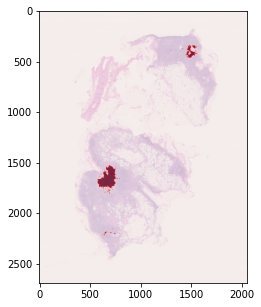

time: 2.27 s (started: 2021-04-30 13:45:26 +00:00)


In [12]:
# load the slide from the tiff file and plot the same
tumor_image = open_slide(tumors_tifs[15])
mask_image = open_slide(tumors_mask_tifs[15])

width = tumor_image.level_dimensions[5][0]
height = tumor_image.level_dimensions[5][1]

tumor_slide = read_slide(tumor_image, 0, 0, 5, width=width, height=height)
mask_slide = read_slide(mask_image, 0, 0, 5, width=width, height=height)
plt.figure(figsize=(5, 5))
plt.imshow(tumor_slide)
plt.imshow(mask_slide[:, :, 0], cmap='Reds', alpha=0.7)
plt.show()



### Removing the gray regions

The idea is to improve the efficiency. 
Gray regions are removed by the following:
- We check for tissue pixels in each wsi (at a given level) by comparing the intensity (code same as that from the project_starter.ipynb).
- Calculate the percentage of tissue pixels in a given slide and threshold the same.
- The threshold percentage used varies depending on the levels of the slides. Generally, for lower levels (0,1,2), the threshold can be higher.

In [48]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

time: 15.1 ms (started: 2021-04-29 20:11:34 +00:00)


In [49]:
# function to find the tissue percentage in a given slide
def find_tissue_percentage(slide_patches):
    tissue_percentage = []
    for slide in slide_patches:
        tissue_pixels = find_tissue_pixels(slide)
        percent_tissue = len(tissue_pixels) / float(slide.shape[0] * slide.shape[0]) * 100
        print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue))
        tissue_percentage.append(percent_tissue)

    return tissue_percentage

time: 12.4 ms (started: 2021-04-29 20:11:35 +00:00)


In [50]:
# function to compare whether the number of tissues in a given slide exceeds a
# certain threshold.
# this is done so as to remove slides with majority amount of gray region in them.
def check_tissue_percentage_threshold(slide_image, threshold_percentage=12):
    tissue_pixels = find_tissue_pixels(slide_image)
    percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
    if percent_tissue < threshold_percentage:
        return False
    return True

time: 4.13 ms (started: 2021-04-29 20:11:37 +00:00)


## Method - 1: Dataset from One Level


### Get patches from the tiff files
The patching process is as follows:
- Load each tiff file to obtain a whole slide image.
- Slide the patch across the image and obtain a slide and mask patch.
- For each patch, check whether the tissue percentage of the patch is above threshold. If not, discard the patch and continue.
- Check the mask patch to determine if a tumor is present in the corresponding patch or not.
- Create a labels array for each patch with binary labeling (0 - normal, 1 - cancerous).


In [79]:
PATCH_SIZE = 32
LEVEL = 4

time: 1.43 ms (started: 2021-04-29 22:14:41 +00:00)


In [80]:
# function for obtaining all the patches along with their labels from one level
# of the slides. 
def get_patches(tumors, masks, patch_size=100, level=5, test_data=False, threshold_percentage=12):

    # list for storing the slide patches extracted from the tifs at level
    slides_patches = []
    # label array indicating the presence/absence of tumor from each patch
    cancerous_patches = []

    for tumor, mask in zip(tumors, masks):
        # get wsi for the tiffs
        tumor_image = open_slide(tumor)
        mask_image = open_slide(mask)

        # strides for the patch
        stride_width = tumor_image.level_dimensions[level][0] // patch_size
        stride_height = tumor_image.level_dimensions[level][1] // patch_size

        # downsampling factor
        downsample_factor = tumor_image.level_downsamples[level]

        print("For tumor: {}".format(tumor))
        print("width, height, downsample: {}, {}, {}".format(stride_width, stride_height, downsample_factor))

        for width in range(stride_width):
            for height in range(stride_height):
                # leftmost x and y co-ordinate of the current patch
                top_x = int(patch_size * width * downsample_factor)
                top_y = int(patch_size * height * downsample_factor)

                # slide patch
                slide_patch = read_slide(tumor_image, top_x, top_y, level, width=patch_size, height=patch_size)
                # mask patch
                mask_patch = read_slide(mask_image, top_x, top_y, level, width=patch_size, height=patch_size)

                # condition for gray region removal
                if test_data == False and check_tissue_percentage_threshold(slide_patch, threshold_percentage) == False:
                    continue

                slides_patches.append(slide_patch)

                # mask indicates tumor presence or absence
                if np.sum(mask_patch[:, :, 0] > 0):
                    cancerous_patches.append(1)
                else:
                    cancerous_patches.append(0)
    return slides_patches, cancerous_patches


time: 38.2 ms (started: 2021-04-29 22:14:46 +00:00)


In [81]:
slides, cancerous = get_patches(tumors_tifs, tumors_mask_tifs, level=LEVEL, patch_size=PATCH_SIZE, threshold_percentage=11)

For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_001.tiff
width, height, downsample: 191, 432, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_002.tif
width, height, downsample: 191, 429, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_005.tif
width, height, downsample: 191, 429, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_012.tif
width, height, downsample: 191, 421, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_016.tif
width, height, downsample: 191, 432, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_019.tif
width, height, downsample: 191, 429, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_023.tif
width, height, downsample: 191, 432, 16.0
For tumor: /content/drive/MyDrive/Columb

In [82]:
print("Number of slides: {}".format(len(slides)))
print("Number of cancerous: {}".format(np.sum(cancerous)))

Number of slides: 146570
Number of cancerous: 8724
time: 24.7 ms (started: 2021-04-29 22:22:04 +00:00)


### Visualizing the dataset

In [84]:
class_names = ['normal', 'cancerous']

time: 1.62 ms (started: 2021-04-29 22:24:26 +00:00)


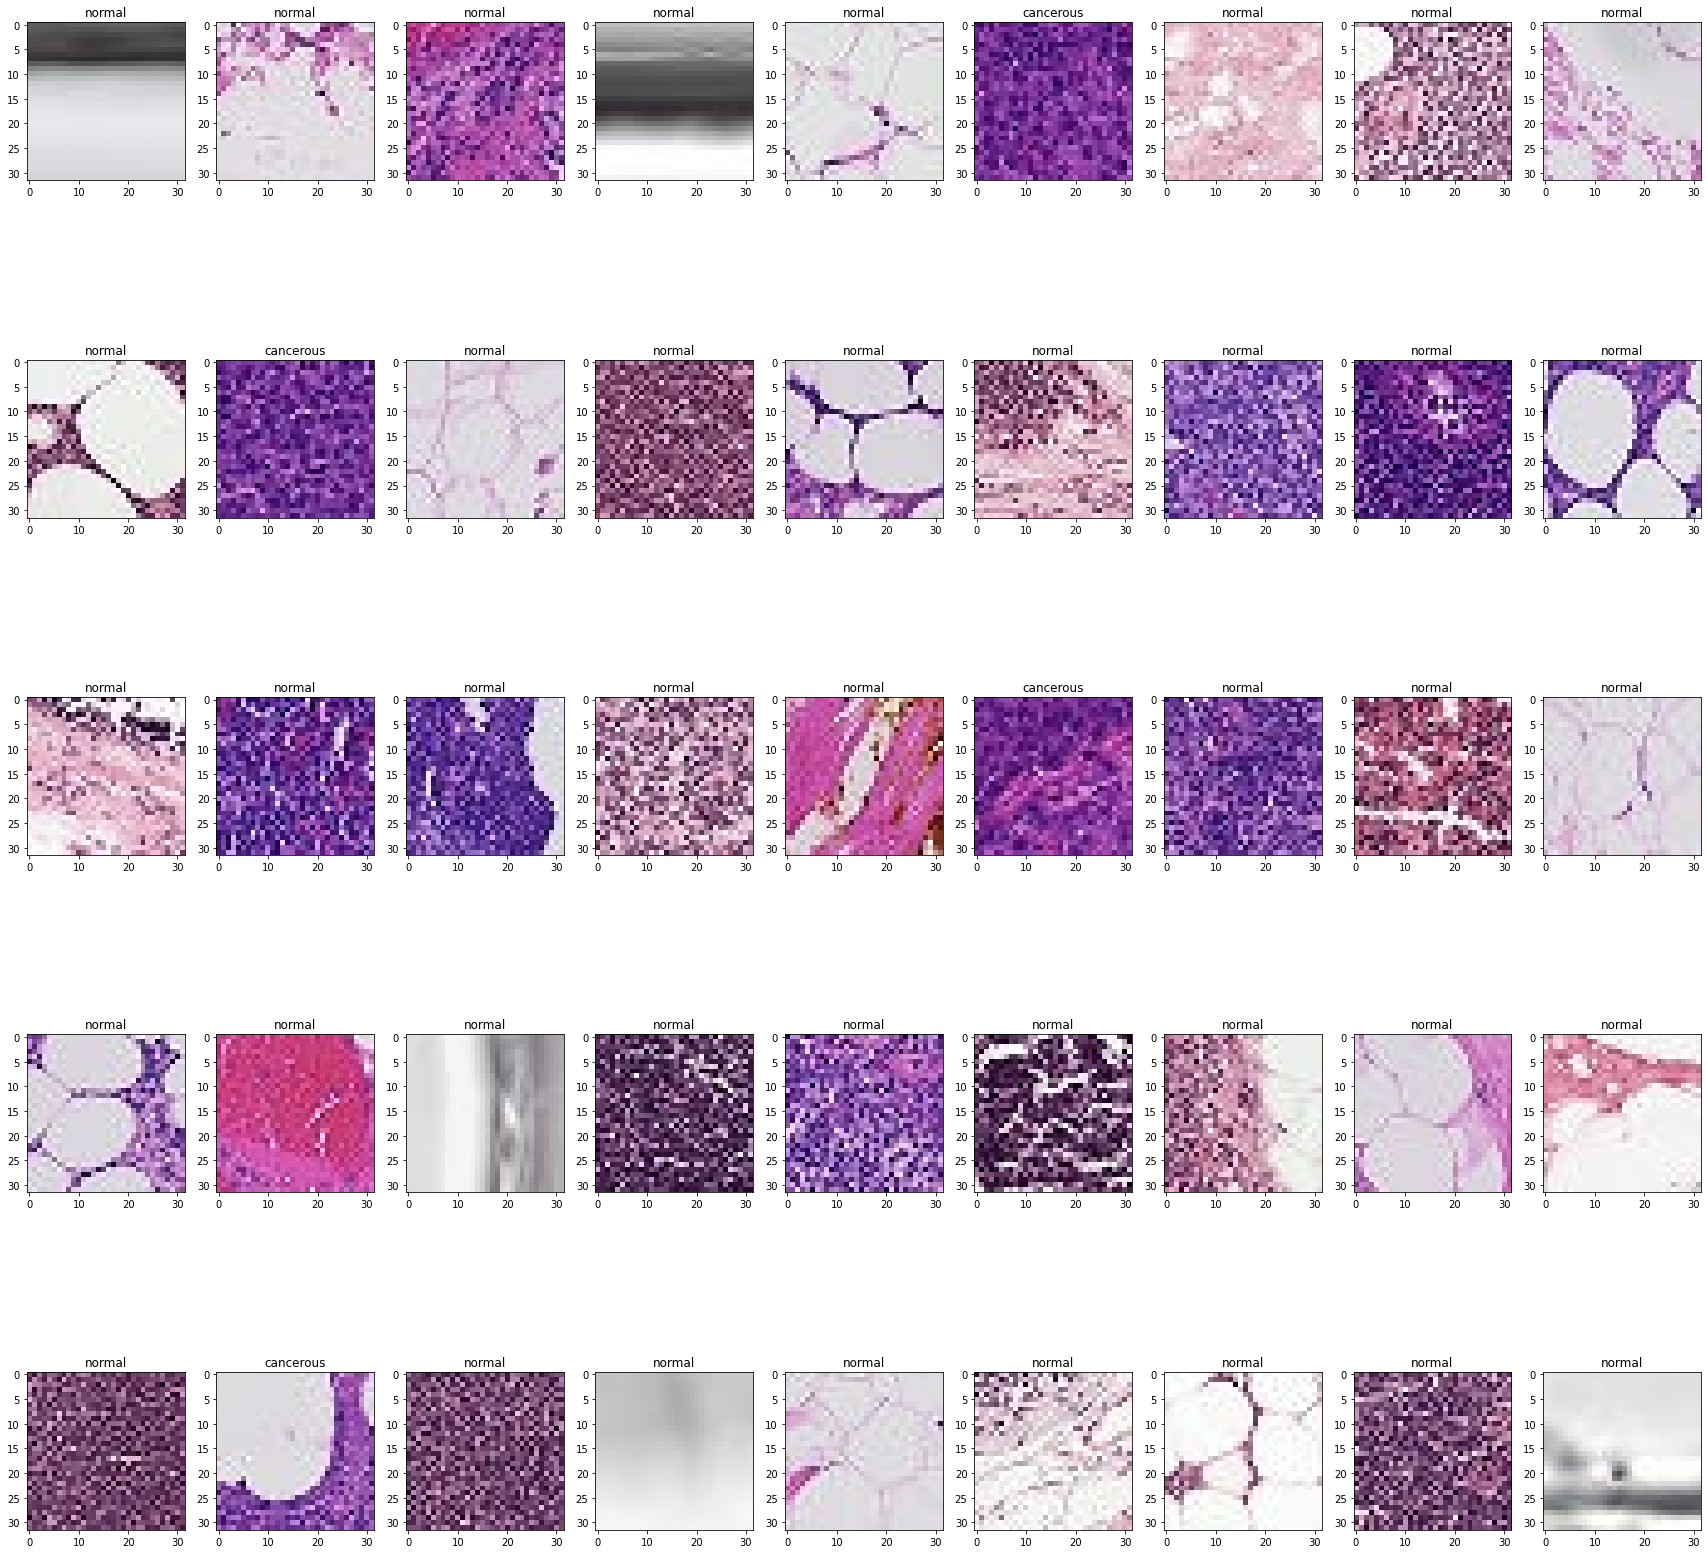

time: 7.51 s (started: 2021-04-29 22:24:31 +00:00)


In [85]:
plt.figure(figsize=(30, 30))
for i in range(45):
    ax = plt.subplot(5, 9, i + 1)
    index = random.randint(0, len(slides))
    plt.imshow(slides[index])
    plt.title(class_names[cancerous[index]])

### Save the patches and the labels in a pickle file

In [86]:
# save the variables to pickle   
variable_path = os.path.join(dataset_path, 'train')
file_name = "camelyon_preprocessed" + "_level" + str(LEVEL) + ".pkl"
if os.path.isdir(variable_path)==False:
    os.mkdir(variable_path)

with open(os.path.join(variable_path, file_name), 'wb') as f:
    pickle.dump([slides, cancerous], f, protocol=-1)

time: 6.43 s (started: 2021-04-29 22:25:14 +00:00)


### Creating the test dataset

Similar to the training dataset, perform patching and create a test dataset. 

Load the same to pickle.

NOTE: Take a note that gray region removal is not done for the test data. Test data is not modified.

In [87]:
test_patches, test_cancerous_patches = get_patches(
    test_tumors_tifs,
    test_tumors_mask_tifs, 
    patch_size=PATCH_SIZE, 
    level=LEVEL, 
    test_data=True # no gray removal for the test data
    )

For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/test/tumor/tumor_101.tif
width, height, downsample: 272, 140, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/test/tumor/tumor_110.tif
width, height, downsample: 184, 140, 16.0
time: 16.5 s (started: 2021-04-29 22:25:37 +00:00)


In [88]:
print("Number of slides: {}".format(len(test_patches)))
print("Number of cancerous: {}".format(np.sum(test_cancerous_patches)))

Number of slides: 63840
Number of cancerous: 5517
time: 17 ms (started: 2021-04-29 22:27:36 +00:00)


In [89]:
# save the variables to pickle 
test_variable_path = os.path.join(dataset_path, 'test')
file_name = "camelyon_preprocessed_test" + "_level" + str(LEVEL) + ".pkl"
if os.path.isdir(test_variable_path)==False:
    os.mkdir(test_variable_path)

with open(os.path.join(test_variable_path, file_name), 'wb') as f:
    pickle.dump([test_patches, test_cancerous_patches], f, protocol=-1)

time: 3.1 s (started: 2021-04-29 22:27:45 +00:00)


### Confirm that the patch extraction process works correctly

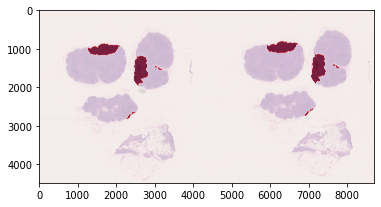

time: 7.5 s (started: 2021-04-29 05:56:31 +00:00)


In [ ]:
# show a slide
tumor_image = open_slide(test_tumors_tifs[0])
mask_image = open_slide(test_tumors_mask_tifs[0])

width = tumor_image.level_dimensions[LEVEL][0]
height = tumor_image.level_dimensions[LEVEL][1]

tumor_slide = read_slide(tumor_image, 0, 0, LEVEL, width=width, height=height)
mask_slide = read_slide(mask_image, 0, 0, LEVEL, width=width, height=height)

plt.imshow(tumor_slide)
plt.imshow(mask_slide[:, :, 0], cmap='Reds', alpha=0.7)
plt.show()

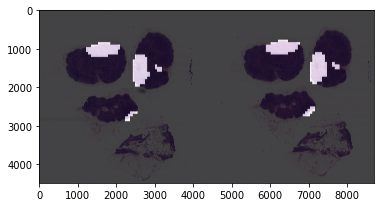

time: 19.3 s (started: 2021-04-29 05:57:00 +00:00)


In [ ]:
# plot the patches to see if patch extraction is working properly
step_width = width // PATCH_SIZE
step_height = height // PATCH_SIZE
canvas_slide = Image.new('RGB', (PATCH_SIZE * step_width, PATCH_SIZE * step_height), 'white')
canvas_mask = Image.new('RGB', (PATCH_SIZE * step_width, PATCH_SIZE * step_height), 'white')
mask_blank = np.zeros((PATCH_SIZE, PATCH_SIZE))
mask_tumor = 255 * np.ones((PATCH_SIZE, PATCH_SIZE))
index = 0

for i in range(step_width):
    for j in range(step_height):
        canvas_slide.paste(Image.fromarray(test_patches[index], 'RGB'), (i*PATCH_SIZE, j*PATCH_SIZE))
        if test_cancerous_patches[index] == 0:
            canvas_mask.paste(Image.fromarray(mask_blank), (i*PATCH_SIZE, j*PATCH_SIZE))
        else:
            canvas_mask.paste(Image.fromarray(mask_tumor), (i*PATCH_SIZE, j*PATCH_SIZE))
        index += 1

slide_name = 'patch_to_slide.png'
mask_name = 'patch_to_mask.png'
canvas_slide.save(slide_name)
canvas_mask.save(mask_name)
image_slide = plt.imread(slide_name)
image_mask = plt.imread(mask_name)

plt.imshow(image_slide)
plt.imshow(image_mask, cmap='Reds', alpha=0.7)

## Method 2: Dataset from multiple zoom levels
The idea behind two zoom levels is to have more high resolution patches, along with keeping some of the surrounding context.

We take two different zoom levels. Extract patches at both levels, combine the same and create the dataset.


In [111]:
PATCH_SIZE = 75
LEVEL_1 = 4
LEVEL_2 = 3

time: 1.68 ms (started: 2021-04-30 00:22:13 +00:00)


The patching process is as follows:
- Take the same size patch at both the levels.
- Align the centres for each patch from the levels, so as to have a corresponding representation of the same patch in each level
- For the patch from a higher zoom level, check whether the tissue percentage of the patch is above threshold. If not, discard the patch and continue.
- Check the mask patch to determine if a tumor is present in the corresponding patch or not.
- Create a labels array for each patch with binary labeling (0 - normal, 1 - cancerous).

### Get Patches from multiple levels

In [99]:
def get_patches_for_multiple_zoom(tumors, masks, patch_size=100, level_1=5, level_2=4, test_data=False, threshold_percentage=12):

    slides_patches = []
    cancerous_patches = []
    # zoom level slides indicates the patches from the lower zoom level, that is
    # level_2
    zoom_level_slides = []

    # factor is nothing but the mapping between the patch size between the two
    # levels. 
    factor = 2 ** (level_1 - level_2)

    for tumor, mask in zip(tumors, masks):
        # get wsi for the tiffs
        tumor_image = open_slide(tumor)
        mask_image = open_slide(mask)

        # strides for the patch
        stride_width = tumor_image.level_dimensions[level_1][0] // patch_size
        stride_height = tumor_image.level_dimensions[level_1][1] // patch_size

        # downsampling factor
        downsample_factor = tumor_image.level_downsamples[level_1]

        print("For tumor: {}".format(tumor))
        print("width, height, downsample: {}, {}, {}".format(stride_width, stride_height, downsample_factor))

        for width in range(stride_width):
            for height in range(stride_height):
                top_x = int(patch_size * width * downsample_factor)
                top_y = int(patch_size * height * downsample_factor)

                # slide patch
                slide_patch = read_slide(tumor_image, top_x, top_y, level_1, width=patch_size, height=patch_size)
                # mask patch
                mask_patch = read_slide(mask_image, top_x, top_y, level_1, width=patch_size, height=patch_size)
                # centre matching
                zoomed_image_patch = read_slide(tumor_image, top_x, top_y, level_2, width = patch_size * factor, height = patch_size * factor)

                if test_data == False and check_tissue_percentage_threshold(slide_patch, threshold_percentage) == False:
                    continue

                slides_patches.append(slide_patch)
                zoom_level_slides.append(zoomed_image_patch)
                if np.sum(mask_patch[:, :, 0] > 0):
                    cancerous_patches.append(1)
                else:
                    cancerous_patches.append(0)
    return slides_patches, zoom_level_slides, cancerous_patches


time: 44.2 ms (started: 2021-04-29 22:42:38 +00:00)


### Crop the patch from lower zoom level

In [105]:
# initially, the patches from the higher zoom level are factor times the PATCH_SIZE
# therefore, we crop out the higher zoom level patches from the centre and extract out
# the patch of size PATCH_SIZE
def crop(image, new_width, new_height, original_shape):
    left = (original_shape[1] - new_width)//2
    top = (original_shape[0] - new_height)//2
    right = (original_shape[1] + new_width)//2
    bottom = (original_shape[0] + new_height)//2
    return image[int(top):int(bottom), int(left):int(right), :]

time: 5.67 ms (started: 2021-04-30 00:17:30 +00:00)


In [100]:
slides, zoomed_slides, cancerous = get_patches_for_multiple_zoom(
    tumors_tifs,
    tumors_mask_tifs, 
    PATCH_SIZE, 
    level_1=LEVEL_1, 
    level_2=LEVEL_2, 
    threshold_percentage=10
    )

For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_001.tiff
width, height, downsample: 81, 184, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_002.tif
width, height, downsample: 81, 183, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_005.tif
width, height, downsample: 81, 183, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_012.tif
width, height, downsample: 81, 179, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_016.tif
width, height, downsample: 81, 184, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_019.tif
width, height, downsample: 81, 183, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/tumor/tumor_023.tif
width, height, downsample: 81, 184, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assi

In [104]:
print("Number of slides: {}".format(len(slides)))
print("Number of cancerous: {}".format(np.sum(cancerous)))

Number of slides: 30065
Number of cancerous: 2016
time: 48.5 ms (started: 2021-04-29 23:59:14 +00:00)


In [106]:
train_zoomed_slides = [crop(image, 75, 75, (150,150)) for image in zoomed_slides]

time: 851 ms (started: 2021-04-30 00:18:08 +00:00)


In [107]:
print("trained zoomed slides shape: ", train_zoomed_slides[0].shape)

trained zoomed slides shape:  (75, 75, 3)
time: 1.39 ms (started: 2021-04-30 00:18:15 +00:00)


In [108]:
# save each patch and labels separately
# save the variables to pickle   
variable_path = os.path.join(dataset_path, 'train')
file_name = "camelyon_preprocessed" + "_level" + str(LEVEL_1) + '_' + str(LEVEL_2) + ".pkl"
if os.path.isdir(variable_path)==False:
    os.mkdir(variable_path)

with open(os.path.join(variable_path, file_name), 'wb') as f:
    pickle.dump([slides, cancerous], f, protocol=-1)

time: 7.8 s (started: 2021-04-30 00:18:39 +00:00)


In [109]:
# save the variables to pickle
variable_path = os.path.join(dataset_path, 'train')
file_name = "camelyon_preprocessed" + "_level" + str(LEVEL_1) + '_' + str(LEVEL_2) + "_zoomed.pkl"
if os.path.isdir(variable_path)==False:
    os.mkdir(variable_path)

with open(os.path.join(variable_path, file_name), 'wb') as f:
    pickle.dump([train_zoomed_slides, cancerous], f, protocol=-1)

time: 10.5 s (started: 2021-04-30 00:19:34 +00:00)


### Test set for mutliple zoom levels

In [112]:
test_patches, test_zoomed_patches, test_cancerous_patches = get_patches_for_multiple_zoom(
    test_tumors_tifs,
    test_tumors_mask_tifs, 
    patch_size=PATCH_SIZE, 
    level_1=LEVEL_1,
    level_2=LEVEL_2, 
    test_data=True,
    threshold_percentage=10
    )

For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/test/tumor/tumor_101.tif
width, height, downsample: 116, 59, 16.0
For tumor: /content/drive/MyDrive/Columbia_Assignments/ADL/Project/dataset/test/tumor/tumor_110.tif
width, height, downsample: 78, 59, 16.0
time: 1min 5s (started: 2021-04-30 00:22:18 +00:00)


In [113]:
print("Number of slides: {}".format(len(test_patches)))
print("Number of zoomed slides: {}".format(len(test_zoomed_patches)))
print("Number of cancerous: {}".format(np.sum(test_cancerous_patches)))

Number of slides: 11446
Number of zoomed slides: 11446
Number of cancerous: 1149
time: 9.34 ms (started: 2021-04-30 00:23:26 +00:00)


In [114]:
# save the variables to pickle   
test_variable_path = os.path.join(dataset_path, 'test')
file_name = "camelyon_preprocessed_test" + "_level" + str(LEVEL_1) + '_' + str(LEVEL_2) + ".pkl"
if os.path.isdir(test_variable_path)==False:
    os.mkdir(test_variable_path)

with open(os.path.join(test_variable_path, file_name), 'wb') as f:
    pickle.dump([test_patches, test_cancerous_patches], f, protocol=-1)

time: 1.82 s (started: 2021-04-30 00:24:29 +00:00)


In [115]:
test_zoomed_slides = [crop(image, 75, 75, (150,150)) for image in test_zoomed_patches]

time: 313 ms (started: 2021-04-30 00:25:32 +00:00)


In [116]:
print(test_zoomed_slides[0].shape)

(75, 75, 3)
time: 1.09 ms (started: 2021-04-30 00:25:47 +00:00)


In [117]:
# save the variables to pickle
# Save the variables    
test_variable_path = os.path.join(dataset_path, 'test')
file_name = "camelyon_preprocessed_test" + "_level" + str(LEVEL_1) + '_' + str(LEVEL_2) + "_zoomed.pkl"
if os.path.isdir(test_variable_path)==False:
    os.mkdir(test_variable_path)

with open(os.path.join(test_variable_path, file_name), 'wb') as f:
    pickle.dump([test_zoomed_slides, test_cancerous_patches], f, protocol=-1)

time: 3.98 s (started: 2021-04-30 00:35:03 +00:00)
